In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib
import pickle
import os 
import matplotlib.pyplot as plt 

In [34]:
df=pd.read_csv('/Users/sanatwalia/Desktop/Assignments_applications/Revenue_Optimization-/dataset/mobile_game_iap_dataset_cleaned.csv')

In [35]:
df.columns

Index(['Date of Purchase', 'Date of Install', 'User Segment', 'Item-Purchased',
       'Session Time', 'Level Reached', 'Prior Purchases', 'Purchase Type',
       'Promo Applied', 'Price (₹)', 'Days Installed Before Last Purchase'],
      dtype='object')

In [36]:
df["Price"]=df['Price (₹)']

In [37]:
df.drop(columns=['Price (₹)'], inplace=True)

In [38]:
df.columns

Index(['Date of Purchase', 'Date of Install', 'User Segment', 'Item-Purchased',
       'Session Time', 'Level Reached', 'Prior Purchases', 'Purchase Type',
       'Promo Applied', 'Days Installed Before Last Purchase', 'Price'],
      dtype='object')

In [39]:
X=df.drop(columns=['Price','Date of Purchase','Date of Install'])
y=df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize the models
# Save the scaler to a file
# Ensure the directory exists
save_dir = '/Users/sanatwalia/Desktop/Assignments_applications/Revenue_Optimization-/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the label encoder as a .pkl file in the 'saved_models' directory
pickle_file_path = os.path.join(save_dir, 'scaler.pkl')

with open(pickle_file_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f'Scaler Encoder  saved to {pickle_file_path}')

Scaler Encoder  saved to /Users/sanatwalia/Desktop/Assignments_applications/Revenue_Optimization-/models/scaler.pkl


In [53]:
X.columns

Index(['User Segment', 'Item-Purchased', 'Session Time', 'Level Reached',
       'Prior Purchases', 'Purchase Type', 'Promo Applied',
       'Days Installed Before Last Purchase'],
      dtype='object')

In [56]:
# Random forest Regressor 
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
rndf_pred = regr.predict(X_test)
print("random forest regressor: ")
print("Mean Squared Error : ", mean_squared_error(y_test, rndf_pred))
print("Mean Absolute Error : ", mean_absolute_error(y_test, rndf_pred))
print("r2 Score : ", r2_score(y_test, rndf_pred))

random forest regressor: 
Mean Squared Error :  1667.5174233999999
Mean Absolute Error :  30.57166
r2 Score :  0.9735074735907104


In [41]:
# Linear Regressor 
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg_pred = linreg.predict(X_test)
print("linear regression: ")
print("Mean Squared Error : ", mean_squared_error(y_test, linreg_pred))
print("Mean Absolute Error : ", mean_absolute_error(y_test, linreg_pred))
print("r2 Score : ", r2_score(y_test, linreg_pred))

linear regression: 
Mean Squared Error :  29366.639057291137
Mean Absolute Error :  141.7975591912258
r2 Score :  0.5334402808271377


In [54]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgboost_pred = model.predict(X_test)
print("linear regression: ")
print("Mean Squared Error : ", mean_squared_error(y_test, xgboost_pred))
print("Mean Absolute Error : ", mean_absolute_error(y_test, xgboost_pred))
print("r2 Score : ", r2_score(y_test, xgboost_pred))

linear regression: 
Mean Squared Error :  1855.824570199605
Mean Absolute Error :  32.15873341369629
r2 Score :  0.970515787601471


In [57]:
import pickle
import os
from sklearn.ensemble import RandomForestRegressor

# Dummy check (assuming you have already trained regr)
print(f"Type of regr: {type(regr)}")  # Should be RandomForestRegressor

# Define save path
save_dir = "/Users/sanatwalia/Desktop/Assignments_applications/Revenue_Optimization-/models"  # Or your desired folder
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
model_path = os.path.join(save_dir, "random_forest_model.pkl")

# Save model with pickle
with open(model_path, "wb") as f:
    pickle.dump(regr, f)

print(f"Model saved successfully to {model_path}")



Type of regr: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Model saved successfully to /Users/sanatwalia/Desktop/Assignments_applications/Revenue_Optimization-/models/random_forest_model.pkl


In [46]:
print("Optimising prices")

Optimising prices


In [49]:
import numpy as np
from scipy.optimize import minimize

#revenue before optimization
revenue_before = np.sum(rndf_pred)

def objective_function(prices):
    #non-linear regularization term for significant deviations where necessary
    regularization_term = np.sum(np.abs(prices - rndf_pred) ** 1.2)
    revenue = -np.sum(prices) + 0.05* regularization_term  #reducing weight of regularization so that optimzation is not non-significant
    return revenue

# Define constraints
#for keeping prices within original range and that optimized revenue is greater than minimum revenue
def constraints(prices, rndf_pred, min_revenue):
    return np.concatenate([
        prices - 0.8 * rndf_pred,
        1.1* rndf_pred - prices,
        [np.sum(prices) - min_revenue]
    ])

# initial price = predicted price
initial_prices = rndf_pred

# Minimum revenue constraint
min_revenue = np.sum(rndf_pred) * 0.96

#bounds
bounds = [(0.8 * price, 1.1 * price) for price in rndf_pred]

#final optimization
result = minimize(objective_function, initial_prices, constraints={'type': 'ineq', 'fun': constraints, 'args': (rndf_pred, min_revenue)}, bounds=bounds)

optimized_prices = result.x

revenue_after = np.sum(optimized_prices)


print("Revenue before optimization:", revenue_before)
print("Revenue after optimization:", revenue_after)


Revenue before optimization: 335441.64
Revenue after optimization: 368985.8039999163


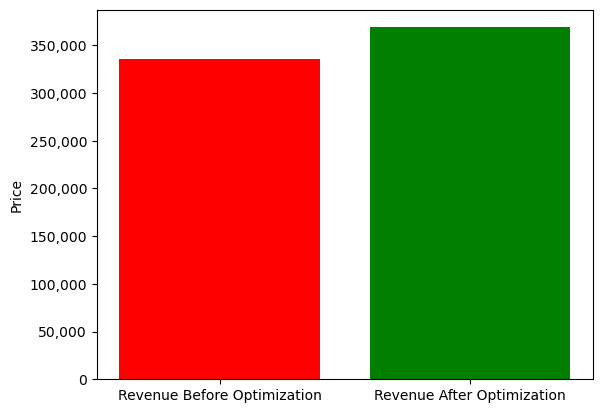

In [50]:

revenue_values = [revenue_before, revenue_after]


labels = ['Revenue Before Optimization', 'Revenue After Optimization']

plt.bar(labels, revenue_values, color=['red', 'green'])
plt.ylabel('Price')

#formatting so that zeroes and commass are shown
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [51]:
prices_df = pd.DataFrame({
    'Predicted Prices': rndf_pred,
    'Optimized Prices': optimized_prices
})
prices_df

,Predicted Prices,Optimized Prices
0,221.19,243.309
1,244.87,269.357
2,858.26,944.086
3,610.28,671.308
4,149.22,164.142
...,...,...
995,86.22,94.842
996,182.06,200.266
997,594.25,653.675
998,495.46,545.006


In [52]:
df.columns

Index(['Date of Purchase', 'Date of Install', 'User Segment', 'Item-Purchased',
       'Session Time', 'Level Reached', 'Prior Purchases', 'Purchase Type',
       'Promo Applied', 'Days Installed Before Last Purchase', 'Price'],
      dtype='object')